In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import genfromtxt
from sklearn import datasets, linear_model
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller

/Users/Shail/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


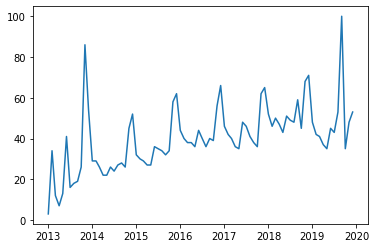

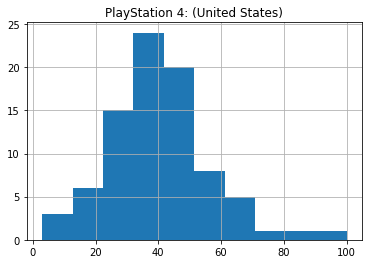

In [2]:

df = pd.read_csv('ps4Data.csv') 
df['Month'] = pd.to_datetime(df['Month']) 
indexedDataset = df.set_index(['Month'])

plt.plot(indexedDataset)

df.hist()
pyplot.show()

In [3]:
from datetime import datetime
indexedDataset.tail(5)

,PlayStation 4: (United States)
Month,
2019-08-01,53
2019-09-01,100
2019-10-01,35
2019-11-01,48
2019-12-01,53


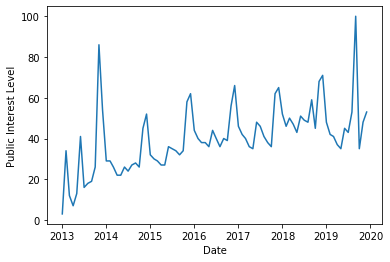

In [4]:
plt.xlabel("Date")
plt.ylabel("Public Interest Level")
plt.plot(indexedDataset)
pd.plotting.register_matplotlib_converters()

In [5]:
# Testing weather it is non-stationary or stationary using ad fuller 
X = df['PlayStation 4: (United States)'].values
result = adfuller(X)

#found online
print('Adf Statistic: %s' %result[0])
print('p-value: %f' %result[1])
print('critical Values:' )
for key, value in result[4].items():
    print('\t%s: %.4f' %(key,value))

Adf Statistic: -1.1861253042880369
p-value: 0.679536
critical Values:
	1%: -3.5246
	5%: -2.9026
	10%: -2.5887


Adf Statistic: -9.5333413196743
p-value: 0.000000
critical Values:
	1%: -3.5246
	5%: -2.9026
	10%: -2.5887


Text(0.5, 1.0, 'Normailzing through Differences')

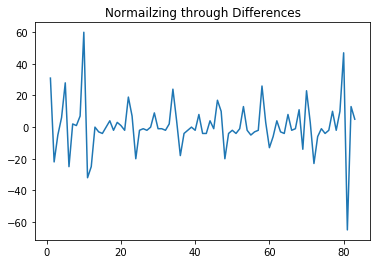

In [6]:
# using diference to normalize the data
df["diff_values"] = df["PlayStation 4: (United States)"].diff()

diff_values = df["diff_values"].values
Y = diff_values[~np.isnan(diff_values)]

#testing if the diffrerencing made the data statoinary 
result = adfuller(Y)
print('Adf Statistic: %s' %result[0])
print('p-value: %f' %result[1])
print('critical Values:' )
for key, value in result[4].items():
    print('\t%s: %.4f' %(key,value))

indexedDataset = df.set_index(['Month']) 
plt.plot(diff_values)
plt.title("Normailzing through Differences")

In [7]:
df = df.iloc[1:]
print(df)

        Month  PlayStation 4: (United States)  diff_values
1  2013-02-01                              34         31.0
2  2013-03-01                              12        -22.0
3  2013-04-01                               7         -5.0
4  2013-05-01                              13          6.0
5  2013-06-01                              41         28.0
..        ...                             ...          ...
79 2019-08-01                              53         10.0
80 2019-09-01                             100         47.0
81 2019-10-01                              35        -65.0
82 2019-11-01                              48         13.0
83 2019-12-01                              53          5.0

[83 rows x 3 columns]


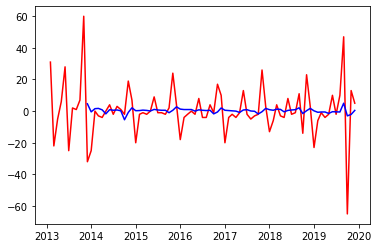

In [49]:
# finding rolling mean of the stationary graph

moving_avg = df.copy()
moving_avg.drop('PlayStation 4: (United States)', axis=1, inplace=True)

moving_avg['Month'] = pd.to_datetime(moving_avg['Month'])
moving_avg["diff_values"] = moving_avg.rolling(window=11).mean()
moving_avg.dropna(inplace=True)
index_avg = moving_avg.set_index(['Month'])

x_month = df['Month']

y_diff = df['diff_values']
plt.plot(x_month, y_diff , color="red")
plt.plot(index_avg, color='blue')


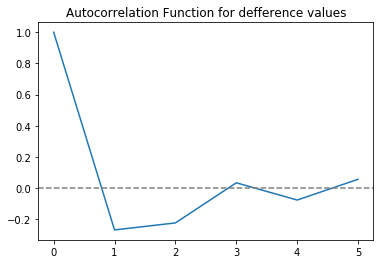

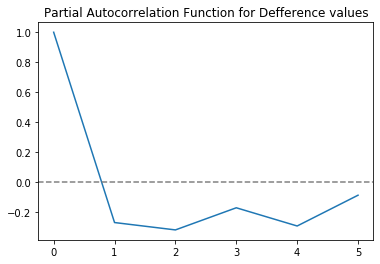

<Figure size 432x288 with 0 Axes>

In [55]:
#Finding acf and pacf to get q and p value to get ARIMA model to work
from statsmodels.tsa.stattools import acf, pacf

acf = acf(df["diff_values"], nlags=5)
pacf = pacf(df["diff_values"], nlags=5, method='ols')


plt.plot(acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Autocorrelation Function for defference values')
plt.show()

plt.plot(pacf)
plt.title('Partial Autocorrelation Function for Defference values')
plt.axhline(y=0,linestyle='--',color='gray')
plt.show()
plt.tight_layout()


/Users/Shail/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/Shail/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


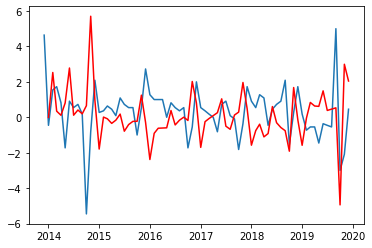

In [59]:
#training ARIMA for difference-moving average method
from statsmodels.tsa.arima_model import ARIMA

df_diff_values_indexed = df.set_index(['Month'])

AR_model = ARIMA(index_avg, order=(1,1,1))
model_fit = AR_model.fit()

plt.plot(index_avg)
plt.plot(model_fit.fittedvalues, color='red')
plt.show()

In [52]:
prediction_ARIMA_series = pd.Series(model_fit.fittedvalues, copy=True)
prediction_ARIMA_cumsum = prediction_ARIMA_series.cumsum()

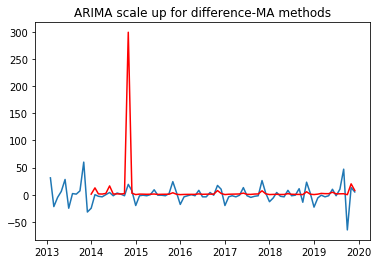

In [68]:
# getting arima model to scale with the original data
# MOST IS NOT MY CODE

prediction_ARIMA_log = pd.Series(df["PlayStation 4: (United States)"].iloc[0], index=df.index)
prediction_ARIMA_log.add(prediction_ARIMA_cumsum, fill_value=0)

prediction_ARIMA = np.exp(prediction_ARIMA_series)

plt.plot(indexedDataset['diff_values'])
plt.title("ARIMA scale up for difference-MA methods")
plt.plot(prediction_ARIMA, color='red')

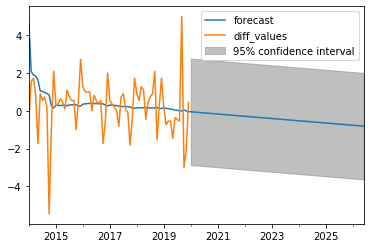

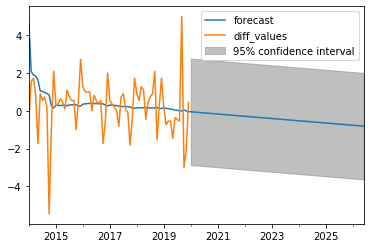

In [54]:
model_fit.plot_predict(1,150)

# Method 2: log transformation

In [42]:
df_log = df.copy()
df_log["PlayStation 4: (United States)"] = np.log(df_log["PlayStation 4: (United States)"])
df_log.drop('diff_values', axis=1, inplace=True)

        Month  PlayStation 4: (United States)
1  2013-02-01                        3.526361
2  2013-03-01                        2.484907
3  2013-04-01                        1.945910
4  2013-05-01                        2.564949
5  2013-06-01                        3.713572
..        ...                             ...
79 2019-08-01                        3.970292
80 2019-09-01                        4.605170
81 2019-10-01                        3.555348
82 2019-11-01                        3.871201
83 2019-12-01                        3.970292

[83 rows x 2 columns]


Text(0.5, 1.0, 'Log of dataframe')

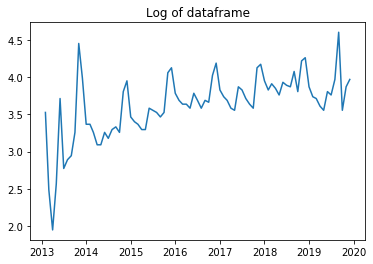

In [15]:
df_log_indexed = df_log.set_index(['Month']) 
print(df_log)
plt.plot(df_log_indexed)
plt.title("Log of dataframe")

In [25]:
# showing that even after log the data is still non-stationary 

X = df_log["PlayStation 4: (United States)"].values
result = adfuller(X)
print('Adf Statistic: %s' %result[0])
print('p-value: %f' %result[1])
print('critical Values:' )
for key, value in result[4].items():
    print('\t%s: %.4f' %(key,value))
    
#df['PlayStation 4: (United States)'] = np.exp(df['PlayStation 4: (United States)'])

Adf Statistic: -2.357677545744799
p-value: 0.154040
critical Values:
	1%: -3.5260
	5%: -2.9032
	10%: -2.5890


In [17]:
# differencing to making normalized data stationary

df_log_diff = df_log.copy()
df_log_diff["PlayStation 4: (United States)"] = df_log_diff["PlayStation 4: (United States)"].diff()
df_log_diff.dropna(inplace=True)

X = df_log_diff['PlayStation 4: (United States)'].values
result = adfuller(X)
print('Adf Statistic: %s' %result[0])
print('p-value: %f' %result[1])
print('critical Values:' )
for key, value in result[4].items():
    print('\t%s: %.4f' %(key,value))

Adf Statistic: -4.764755456840321
p-value: 0.000063
critical Values:
	1%: -3.5274
	5%: -2.9038
	10%: -2.5893


# ACF and PACF - finding unit roots

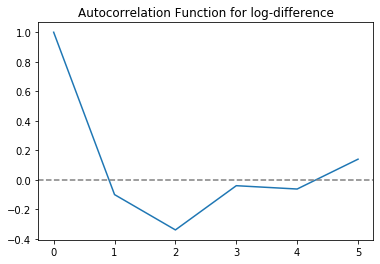

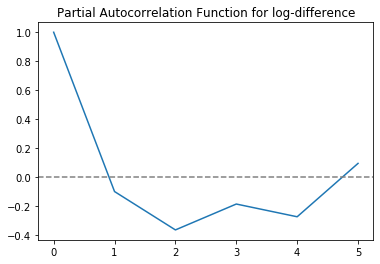

<Figure size 432x288 with 0 Axes>

In [56]:
# finding ACF and PACF to get the unit roots for ARIMA model of moving average of the difference dataset  
from statsmodels.tsa.stattools import acf, pacf



acf = acf(df_log_diff["PlayStation 4: (United States)"], nlags=5)
pacf = pacf(df_log_diff["PlayStation 4: (United States)"], nlags=5, method='ols')


plt.plot(acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Autocorrelation Function for log-difference')
plt.show()


plt.plot(pacf)
plt.title('Partial Autocorrelation Function for log-difference')
plt.axhline(y=0,linestyle='--',color='gray')
plt.show()
plt.tight_layout()
#q= 3.1 , p= 1.8 

#ARIMA MODEL Applied to Difference data set

In [19]:
print(model_fit.fittedvalues)
prediction_ARIMA_series = pd.Series(model_fit.fittedvalues, copy=True)
print(prediction_ARIMA_series)

Month
2013-12-01    0.322795
2014-01-01    0.822369
2014-02-01   -0.202052
2014-03-01    0.940525
2014-04-01   -0.013617
                ...   
2019-08-01    0.203420
2019-09-01    0.287361
2019-10-01    1.116371
2019-11-01   -0.923533
2019-12-01    1.036589
Length: 73, dtype: float64
Month
2013-12-01    0.322795
2014-01-01    0.822369
2014-02-01   -0.202052
2014-03-01    0.940525
2014-04-01   -0.013617
                ...   
2019-08-01    0.203420
2019-09-01    0.287361
2019-10-01    1.116371
2019-11-01   -0.923533
2019-12-01    1.036589
Length: 73, dtype: float64


            PlayStation 4: (United States)
Month                                     
2013-02-01                        3.526361
2013-03-01                        2.484907
2013-04-01                        1.945910
2013-05-01                        2.564949
2013-06-01                        3.713572
...                                    ...
2019-08-01                        3.970292
2019-09-01                        4.605170
2019-10-01                        3.555348
2019-11-01                        3.871201
2019-12-01                        3.970292

[83 rows x 1 columns]


/Users/Shail/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/Shail/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


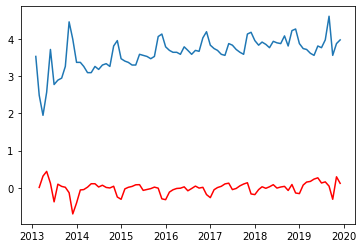

In [64]:
#geting the ARIMA model for Log difference

from statsmodels.tsa.arima_model import ARIMA


df_log['Month'] = pd.to_datetime(df['Month'])
log_diff_indexed = df_log.set_index(['Month']) 
print(df_log_indexed)

AR_model = ARIMA(log_diff_indexed, order=(1,1,1))
model_fit = AR_model.fit(disp=-1)

plt.plot(df_log_indexed)
plt.plot(model_fit.fittedvalues, color='red')
plt.show()

In [65]:
prediction_ARIMA_cumsum = prediction_ARIMA_series.cumsum()

Month
2014-01-01     0.990165
2014-02-01    12.521677
2014-03-01     1.411157
2014-04-01     1.118876
2014-05-01     2.239449
                ...    
2019-08-01     1.582968
2019-09-01     1.702763
2019-10-01     0.007122
2019-11-01    19.936977
2019-12-01     7.735433
Length: 72, dtype: float64


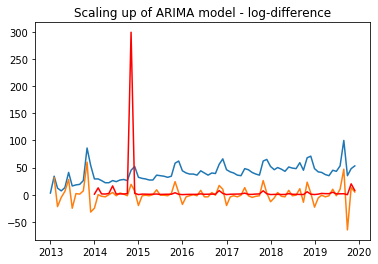

In [69]:

prediction_ARIMA_log = pd.Series(df["PlayStation 4: (United States)"].iloc[0], index=df_log.index)
#cumsum found online reference
prediction_ARIMA_log.add(prediction_ARIMA_cumsum, fill_value=0)

prediction_ARIMA = np.exp(prediction_ARIMA_series)

print(prediction_ARIMA)
plt.plot(indexedDataset)
plt.title("Scaling up of ARIMA model - log-difference")
plt.plot(prediction_ARIMA, color='red')

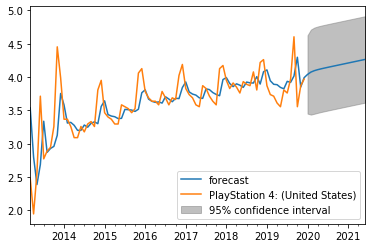

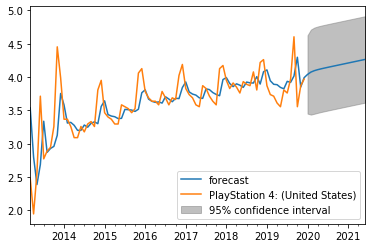

In [67]:
model_fit.plot_predict(1,100)